In [45]:
import numpy as np
import pandas as pd # read the csv
import re # regex to detect username, url, html entity 
import nltk # to use word tokenize (split the sentence into words)
from nltk.corpus import stopwords # to remove the stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from keras.utils import to_categorical
from keras import backend as K

In [46]:
data = pd.read_csv("train.csv")

data.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [47]:
# dataset shape to know how many tweets in the datasets
print(f"num of tweets: {data.shape}")

# extract the text and labels
tweet = list(data['tweet'])
labels = list(data['class'])

num of tweets: (24783, 6)


In [48]:
import re
import string

# Define stopwords manually or use a predefined list
stop_words = set([
    "a", "an", "the", "is", "in", "on", "at", "to", "for", "and", "or", "of", "with", "by", "as", "that", "this", "it",
    "be", "was", "were", "been", "am", "are", "rt", "user"
])

def remove_entity(text):
    return re.sub(r"&[^\s;]+;", "", text)

def change_user(text):
    return re.sub(r"@\w+", "user", text)

def remove_url(text):
    return re.sub(r"http\S+|www\S+", "", text)

def remove_noise_symbols(text):
    return text.translate(str.maketrans("", "", string.punctuation))

def remove_stopwords(text):
    words = text.split()  # Simple tokenization
    return " ".join(word for word in words if word.lower() not in stop_words)

def preprocess(text):
    text = change_user(text)
    text = remove_entity(text)
    text = remove_url(text)
    text = remove_noise_symbols(text)
    text = remove_stopwords(text)
    return text

In [49]:
# call the cleaning function
clean_tweets = [preprocess(tweet) for tweet in tweet]  
print(clean_tweets)

['woman you shouldnt complain about cleaning up your house man you should always take trash out', 'boy dats coldtyga dwn bad cuffin dat hoe 1st place', 'Dawg You ever fuck bitch she start cry You confused shit', 'she look like tranny', 'shit you hear about me might true might faker than bitch who told ya', 'shit just blows meclaim you so faithful down somebody but still fucking hoes', 'I can not just sit up HATE another bitch I got too much shit going', 'cause Im tired you big bitches coming us skinny girls', 'you might not get ya bitch back thats', 'hobbies include fighting Mariam bitch', 'Keeks bitch she curves everyone lol I walked into conversation like Smh', 'Murda Gang bitch its Gang Land', 'So hoes smoke losers yea go IG', 'bad bitches only thing i like', 'bitch get up off me', 'bitch nigga miss me', 'bitch plz whatever', 'bitch who do you love', 'bitches get cut off everyday B', 'black bottle bad bitch', 'broke bitch cant tell me nothing', 'cancel bitch like Nino', 'cant you se

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(clean_tweets, labels, test_size=0.2, random_state=42)

In [51]:
## Tokenizing -> basically we use tokenisation for many things, its commonly used for feature extraction in preprocessing. btw idk how it works as feature extraction tho :(
# declare the tokenizer
tokenizer = Tokenizer()
# build the vocabulary based on train dataset
tokenizer.fit_on_texts(X_train)
# tokenize the train and test dataset
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# vocabulary size (num of unique words) -> will be used in embedding layer
vocab_size = len(tokenizer.word_index) + 1

In [52]:
## Padding -> to uniform the datas
max_length = max(len(seq) for seq in X_train)

# to test an outlier case (if one of the test dataset has longer length)
for x in X_test:
    if len(x) > max_length:
        print(f"an outlier detected: {x}")

X_train = pad_sequences(X_train, maxlen = max_length)
X_test = pad_sequences(X_test, maxlen = max_length)

In [53]:
# create hot_labels (idk whty tapi ini penting, kalo ga bakal error)
y_test = to_categorical(y_test, num_classes=3)
y_train = to_categorical(y_train, num_classes=3)

In [54]:
# another look on the number of tweet in test and training data

print(f"num test tweet: {y_test.shape[0]}")
print(f"num train tweet: {y_train.shape[0]}")

num test tweet: 4957
num train tweet: 19826


In [61]:
import tensorflow.keras.backend as K  # Correct import

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2 * (precisions * recalls) / (precisions + recalls + K.epsilon())


In [65]:
from tensorflow.keras.metrics import Metric
import tensorflow.keras.backend as K

class F1Score(Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name="f1", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        prec = precision(y_true, y_pred)  # Call the function correctly
        rec = recall(y_true, y_pred)
        self.f1.assign(2 * (prec * rec) / (prec + rec + K.epsilon()))

    def result(self):
        return self.f1

    def reset_state(self):
        self.f1.assign(0)

# Use it in model.compile()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', F1Score()])


In [66]:
# checking the model parameters
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 30, 200)        │     3,907,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        67,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,983,547 (15.20 MB)

 Trainable params: 3,983,547 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# using LSTM
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split

# Load your dataset (Assuming a CSV format for simplicity)
# Let's assume dataset columns are: 'text' for tweet content and 'label' for the target
df = pd.read_csv('train.csv')  # Adjust the path to your dataset file
# Preprocess the text (remove special characters and lowercase the text)
df['tweet'] = df['tweet'].str.replace(r'[^a-zA-Z0-9\s@]', '', regex=True)
df['tweet'] = df['tweet'].str.lower()

# Split the dataset into training and testing (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df['tweet'].values, df['class'].values, test_size=0.2, random_state=42)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure consistent length
max_length = 100  # You can adjust this as needed
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=3)  # Assuming 3 classes (0, 1, 2)
y_test_encoded = to_categorical(y_test, num_classes=3)

# Build the LSTM model
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 for padding

model = Sequential([
    Embedding(vocab_size, 200, input_length=max_length),
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_history = model.fit(
    X_train_padded, 
    y_train_encoded, 
    batch_size=64, 
    epochs=10, 
    validation_data=(X_test_padded, y_test_encoded)
)

# After training, you can evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print(f"Test Accuracy: {accuracy}")

# Optional: Make predictions on new data
predictions = model.predict(X_test_padded)

Epoch 1/10


c:\Users\Denzel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


310/310 ━━━━━━━━━━━━━━━━━━━━ 30s 89ms/step - accuracy: 0.7866 - loss: 0.6335 - val_accuracy: 0.8860 - val_loss: 0.3435
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.9177 - loss: 0.2717 - val_accuracy: 0.8751 - val_loss: 0.3534
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.9469 - loss: 0.1518 - val_accuracy: 0.8695 - val_loss: 0.4504
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - accuracy: 0.9744 - loss: 0.0816 - val_accuracy: 0.8677 - val_loss: 0.5631
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 29s 95ms/step - accuracy: 0.9829 - loss: 0.0555 - val_accuracy: 0.8566 - val_loss: 0.6096
Epoch 6/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 30s 97ms/step - accuracy: 0.9866 - loss: 0.0385 - val_accuracy: 0.8630 - val_loss: 0.6323
Epoch 7/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 28s 92ms/step - accuracy: 0.9935 - loss: 0.0220 - val_accuracy: 0.8669 - val_loss: 0.7760
Epoch 8/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step - accuracy: 0.9948 - loss: 0.0181 - val_accurac

In [ ]:
# removed more redundant words
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

# Load your dataset (Assuming a CSV format for simplicity)
df = pd.read_csv('train.csv')  # Adjust the path to your dataset file

# Define stop words and preprocess functions
stop_words = set(stopwords.words('english'))
stop_words.add("rt")

def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "user", raw_text)
    return text

def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)
    return text

def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')
    return text

# Apply all text cleaning functions
def preprocess_text(raw_text):
    text = raw_text.lower()  # Lowercase the text
    text = remove_entity(text)
    text = change_user(text)
    text = remove_url(text)
    text = remove_noise_symbols(text)
    return text

# Preprocess the tweet column in the dataset
df['tweet'] = df['tweet'].apply(preprocess_text)

# Split the dataset into training and testing (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df['tweet'].values, df['class'].values, test_size=0.2, random_state=42)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure consistent length
max_length = 100  # You can adjust this as needed
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=3)  # Assuming 3 classes (0, 1, 2)
y_test_encoded = to_categorical(y_test, num_classes=3)

# Build the LSTM model
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 for padding

model = Sequential([
    Embedding(vocab_size, 200, input_length=max_length),
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_history = model.fit(
    X_train_padded, 
    y_train_encoded, 
    batch_size=64, 
    epochs=10, 
    validation_data=(X_test_padded, y_test_encoded)
)

# After training, you can evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print(f"Test Accuracy: {accuracy}")

# Optional: Make predictions on new data
predictions = model.predict(X_test_padded)


Epoch 1/10


c:\Users\Denzel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


310/310 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - accuracy: 0.7887 - loss: 0.6308 - val_accuracy: 0.8856 - val_loss: 0.3419
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.9086 - loss: 0.2796 - val_accuracy: 0.8907 - val_loss: 0.3060
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.9408 - loss: 0.1735 - val_accuracy: 0.8860 - val_loss: 0.3734
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.9597 - loss: 0.1218 - val_accuracy: 0.8763 - val_loss: 0.4177
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.9673 - loss: 0.0940 - val_accuracy: 0.8638 - val_loss: 0.5962
Epoch 6/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.9751 - loss: 0.0709 - val_accuracy: 0.8665 - val_loss: 0.5242
Epoch 7/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.9762 - loss: 0.0658 - val_accuracy: 0.8721 - val_loss: 0.6266
Epoch 8/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - accuracy: 0.9801 - loss: 0.0555 - val_accurac

In [ ]:
# early stop implementation
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

# Load your dataset (Assuming a CSV format for simplicity)
df = pd.read_csv('train.csv')  # Adjust the path to your dataset file

# Define stop words and preprocess functions
stop_words = set(stopwords.words('english'))
stop_words.add("rt")

def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "user", raw_text)
    return text

def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)
    return text

def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')
    return text

# Apply all text cleaning functions
def preprocess_text(raw_text):
    text = raw_text.lower()  # Lowercase the text
    text = remove_entity(text)
    text = change_user(text)
    text = remove_url(text)
    text = remove_noise_symbols(text)
    return text

# Preprocess the tweet column in the dataset
df['tweet'] = df['tweet'].apply(preprocess_text)

# Split the dataset into training and testing (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df['tweet'].values, df['class'].values, test_size=0.2, random_state=42)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure consistent length
max_length = 100  # You can adjust this as needed
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=3)  # Assuming 3 classes (0, 1, 2)
y_test_encoded = to_categorical(y_test, num_classes=3)

# Build the LSTM model
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 for padding

model = Sequential([
    Embedding(vocab_size, 200, input_length=max_length),
    LSTM(64, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_history = model.fit(
    X_train_padded, 
    y_train_encoded, 
    batch_size=64, 
    epochs=10, 
    validation_data=(X_test_padded, y_test_encoded),
    callbacks=[early_stopping]
)

# After training, you can evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print(f"Test Accuracy: {accuracy}")

# Optional: Make predictions on new data
predictions = model.predict(X_test_padded)


Epoch 1/10


c:\Users\Denzel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


310/310 ━━━━━━━━━━━━━━━━━━━━ 59s 172ms/step - accuracy: 0.7724 - loss: 1.8202 - val_accuracy: 0.8650 - val_loss: 0.4517
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 48s 154ms/step - accuracy: 0.8864 - loss: 0.4093 - val_accuracy: 0.8848 - val_loss: 0.3839
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 52s 167ms/step - accuracy: 0.9189 - loss: 0.3070 - val_accuracy: 0.8836 - val_loss: 0.4033
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 50s 161ms/step - accuracy: 0.9266 - loss: 0.2844 - val_accuracy: 0.8800 - val_loss: 0.4343
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 50s 162ms/step - accuracy: 0.9281 - loss: 0.2600 - val_accuracy: 0.8804 - val_loss: 0.4358
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8819 - loss: 0.3837
Test Accuracy: 0.8848093748092651
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


In [ ]:
# using GRU
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

# Load your dataset (Assuming a CSV format for simplicity)
df = pd.read_csv('train.csv')  # Adjust the path to your dataset file

# Define stop words and preprocess functions
stop_words = set(stopwords.words('english'))
stop_words.add("rt")

def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "user", raw_text)
    return text

def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)
    return text

def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')
    return text

# Apply all text cleaning functions
def preprocess_text(raw_text):
    text = raw_text.lower()  # Lowercase the text
    text = remove_entity(text)
    text = change_user(text)
    text = remove_url(text)
    text = remove_noise_symbols(text)
    return text

# Preprocess the tweet column in the dataset
df['tweet'] = df['tweet'].apply(preprocess_text)

# Split the dataset into training and testing (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df['tweet'].values, df['class'].values, test_size=0.2, random_state=42)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure consistent length
max_length = 100  # You can adjust this as needed
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=3)  # Assuming 3 classes (0, 1, 2)
y_test_encoded = to_categorical(y_test, num_classes=3)

# Build the LSTM model
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 for padding

model = Sequential([
    Embedding(vocab_size, 200, input_length=max_length),
    GRU(64, dropout=0.3, recurrent_dropout=0.3),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_history = model.fit(
    X_train_padded, 
    y_train_encoded, 
    batch_size=64, 
    epochs=10, 
    validation_data=(X_test_padded, y_test_encoded),
    callbacks=[early_stopping]
)

# After training, you can evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print(f"Test Accuracy: {accuracy}")

# Optional: Make predictions on new data
predictions = model.predict(X_test_padded)


Epoch 1/10


c:\Users\Denzel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


310/310 ━━━━━━━━━━━━━━━━━━━━ 60s 177ms/step - accuracy: 0.7903 - loss: 0.6137 - val_accuracy: 0.8864 - val_loss: 0.3281
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 51s 164ms/step - accuracy: 0.9141 - loss: 0.2666 - val_accuracy: 0.8874 - val_loss: 0.3098
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 44s 141ms/step - accuracy: 0.9364 - loss: 0.1878 - val_accuracy: 0.8836 - val_loss: 0.3279
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 44s 140ms/step - accuracy: 0.9509 - loss: 0.1411 - val_accuracy: 0.8820 - val_loss: 0.3941
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 42s 136ms/step - accuracy: 0.9645 - loss: 0.1056 - val_accuracy: 0.8806 - val_loss: 0.4669
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8877 - loss: 0.3012
Test Accuracy: 0.8874319195747375
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


In [3]:
#using bidirectional
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

# Load your dataset (Assuming a CSV format for simplicity)
df = pd.read_csv('train.csv')  # Adjust the path to your dataset file

# Define stop words and preprocess functions
stop_words = set(stopwords.words('english'))
stop_words.add("rt")

def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "user", raw_text)
    return text

def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)
    return text

def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')
    return text

# Apply all text cleaning functions
def preprocess_text(raw_text):
    text = raw_text.lower()  # Lowercase the text
    text = remove_entity(text)
    text = change_user(text)
    text = remove_url(text)
    text = remove_noise_symbols(text)
    return text

# Preprocess the tweet column in the dataset
df['tweet'] = df['tweet'].apply(preprocess_text)

# Split the dataset into training and testing (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df['tweet'].values, df['class'].values, test_size=0.2, random_state=42)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure consistent length
max_length = 100  # You can adjust this as needed
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=3)  # Assuming 3 classes (0, 1, 2)
y_test_encoded = to_categorical(y_test, num_classes=3)

# Build the LSTM model
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 for padding

model = Sequential([
    Embedding(vocab_size, 200, input_length=max_length),
    Bidirectional(GRU(64, dropout=0.3, recurrent_dropout=0.3)),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_history = model.fit(
    X_train_padded, 
    y_train_encoded, 
    batch_size=64, 
    epochs=10, 
    validation_data=(X_test_padded, y_test_encoded),
    callbacks=[early_stopping]
)

# After training, you can evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print(f"Test Accuracy: {accuracy}")

# Optional: Make predictions on new data
predictions = model.predict(X_test_padded)


Epoch 1/10


c:\Users\Denzel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


310/310 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - accuracy: 0.8000 - loss: 0.5787 - val_accuracy: 0.8947 - val_loss: 0.3230
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.9119 - loss: 0.2792 - val_accuracy: 0.8953 - val_loss: 0.3085
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 32s 103ms/step - accuracy: 0.9331 - loss: 0.2012 - val_accuracy: 0.8907 - val_loss: 0.3531
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 32s 103ms/step - accuracy: 0.9487 - loss: 0.1470 - val_accuracy: 0.8788 - val_loss: 0.3975
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 33s 105ms/step - accuracy: 0.9650 - loss: 0.1070 - val_accuracy: 0.8808 - val_loss: 0.4468
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8984 - loss: 0.3030
Test Accuracy: 0.8952995538711548
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [9]:
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

# Load your dataset (Assuming a CSV format for simplicity)
df = pd.read_csv('train.csv')  # Adjust the path to your dataset file

# Define stop words and preprocess functions
stop_words = set(stopwords.words('english'))
stop_words.add("rt")

def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "user", raw_text)
    return text

def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)
    return text

def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')
    return text

# Apply all text cleaning functions
def preprocess_text(raw_text):
    text = raw_text.lower()  # Lowercase the text
    text = remove_entity(text)
    text = change_user(text)
    text = remove_url(text)
    text = remove_noise_symbols(text)
    return text

# Preprocess the tweet column in the dataset
df['tweet'] = df['tweet'].apply(preprocess_text)

# Split the dataset into training and testing (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df['tweet'].values, df['class'].values, test_size=0.2, random_state=42)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure consistent length
max_length = 100  # You can adjust this as needed
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=3)  # Assuming 3 classes (0, 1, 2)
y_test_encoded = to_categorical(y_test, num_classes=3)

# Build the LSTM model
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 for padding

model = Sequential([
    Embedding(vocab_size, 200, input_length=max_length),  # Trainable embedding layer
    Bidirectional(GRU(64, dropout=0.3, recurrent_dropout=0.3)),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
model_history = model.fit(
    X_train_padded, 
    y_train_encoded, 
    batch_size=64, 
    epochs=10, 
    validation_data=(X_test_padded, y_test_encoded),
    callbacks=[early_stopping]
)

# After training, you can evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print(f"Test Accuracy: {accuracy}")

# Optional: Make predictions on new data
predictions = model.predict(X_test_padded)


Epoch 1/10


c:\Users\Denzel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


310/310 ━━━━━━━━━━━━━━━━━━━━ 51s 154ms/step - accuracy: 0.8066 - loss: 0.5743 - val_accuracy: 0.8945 - val_loss: 0.3215
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 48s 156ms/step - accuracy: 0.9126 - loss: 0.2738 - val_accuracy: 0.8935 - val_loss: 0.3060
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - accuracy: 0.9328 - loss: 0.1970 - val_accuracy: 0.8850 - val_loss: 0.3327
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 50s 162ms/step - accuracy: 0.9486 - loss: 0.1486 - val_accuracy: 0.8856 - val_loss: 0.3917
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 48s 156ms/step - accuracy: 0.9585 - loss: 0.1202 - val_accuracy: 0.8808 - val_loss: 0.4664
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8929 - loss: 0.2995
Test Accuracy: 0.8934839367866516
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step


In [18]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Load the dataset
df = pd.read_csv('train.csv')  # Adjust the path to your dataset file

# Preprocessing functions
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "user", raw_text)
    return text

def remove_url(raw_text):
    url_regex = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
    text = re.sub(url_regex, '', raw_text)
    return text

def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')
    return text

def preprocess_text(raw_text):
    text = raw_text.lower()  # Lowercase the text
    text = remove_entity(text)
    text = change_user(text)
    text = remove_url(text)
    text = remove_noise_symbols(text)
    return text

# Preprocess the tweet column
df['tweet'] = df['tweet'].apply(preprocess_text)

# Split the dataset into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df['tweet'].values, df['class'].values, test_size=0.2, random_state=42)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure consistent length
max_length = 100  # You can adjust this as needed
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=3)  # Assuming 3 classes (0, 1, 2)
y_test_encoded = to_categorical(y_test, num_classes=3)

# Build the GRU model
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 for padding

model = Sequential([
    Embedding(vocab_size, 200, input_length=max_length),
    GRU(128, dropout=0.4, recurrent_dropout=0.4),  # GRU layer for better performance
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=1e-4)  # Lower learning rate for better convergence
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Set callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-6)

# Train the model
model_history = model.fit(
    X_train_padded, 
    y_train_encoded, 
    batch_size=64, 
    epochs=10, 
    validation_data=(X_test_padded, y_test_encoded),
    callbacks=[early_stopping, lr_reduction]
)

# After training, evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print(f"Test Accuracy: {accuracy}")

# Optional: Make predictions on new data
predictions = model.predict(X_test_padded)


Epoch 1/10


c:\Users\Denzel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


310/310 ━━━━━━━━━━━━━━━━━━━━ 33s 101ms/step - accuracy: 0.6221 - loss: 0.9494 - val_accuracy: 0.7730 - val_loss: 0.5841 - learning_rate: 1.0000e-04
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 34s 110ms/step - accuracy: 0.7786 - loss: 0.5651 - val_accuracy: 0.8233 - val_loss: 0.4609 - learning_rate: 1.0000e-04
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 34s 110ms/step - accuracy: 0.8505 - loss: 0.4277 - val_accuracy: 0.8650 - val_loss: 0.3881 - learning_rate: 1.0000e-04
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 35s 114ms/step - accuracy: 0.8911 - loss: 0.3469 - val_accuracy: 0.8755 - val_loss: 0.3608 - learning_rate: 1.0000e-04
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 36s 115ms/step - accuracy: 0.9109 - loss: 0.2956 - val_accuracy: 0.8804 - val_loss: 0.3525 - learning_rate: 1.0000e-04
Epoch 6/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 36s 114ms/step - accuracy: 0.9166 - loss: 0.2758 - val_accuracy: 0.8798 - val_loss: 0.3600 - learning_rate: 1.0000e-04
Epoch 7/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 36s 117ms/step - 

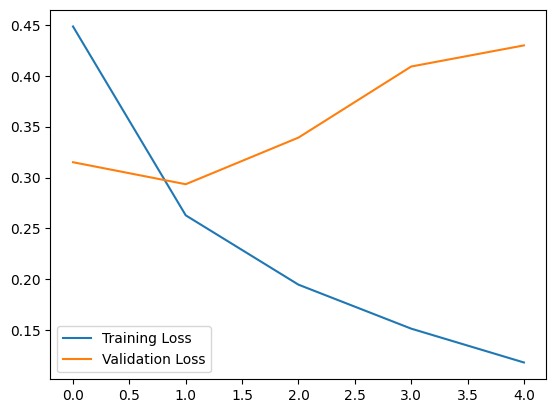

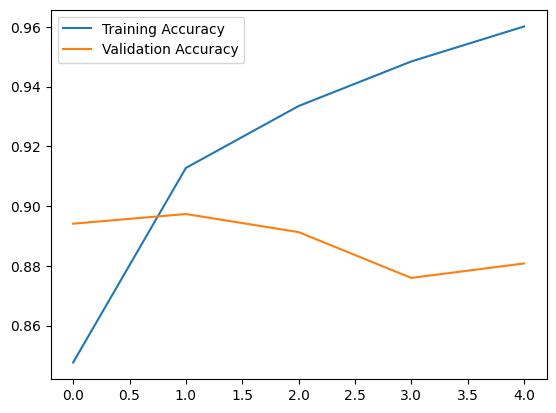

In [86]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()